# Argo Sample Rate

This notebook will investigate the sample rate of argo floats and how to account for this while loading boxes, interpolating to a standard pressure grid, and performing analysis. This is important to resolve because some (many?) profiles seem to have sampling rates of >100m, which would greatly interfere with the accuracy of filtering analysis, particularly at small scales. See this issue for more specific thoughts on how to address this: https://github.com/ocean-transport/argo-intern/issues/12#issuecomment-1655683014

In [2]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd

In [13]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf
import processing_funcs as prf

In [14]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)
reload(prf)

<module 'processing_funcs' from '/home/amf2288/argo-intern/funcs/processing_funcs.py'>

In [ ]:
#ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-25,-23)_lat:(-70,70)_ds_z.nc')

In [6]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader=ArgoDataFetcher(src='gdac',ftp="/swot/SUM05/dbalwada/Argo_sync",parallel=True,progress=True)

ds = argo_loader.region([-25,-23,-70,70,0,2001])
print('loading points complete')
ds = ds.to_xarray()
print('to xarray complete')
ds = ds.argo.point2profile()
print('point to profile complete')

loading points complete


100%|██████████| 1849/1849 [1:34:43<00:00,  3.07s/it]


to xarray complete
point to profile complete


In [7]:
depth_min, depth_max = 0, 2000
rate = 4

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<rate,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)

ds_rate = ds_sel.PRES.diff('N_LEVELS').sortby('N_PROF')

In [8]:
#does diff reduce by one, when adding sample_rate as variable does it fill last point with nan

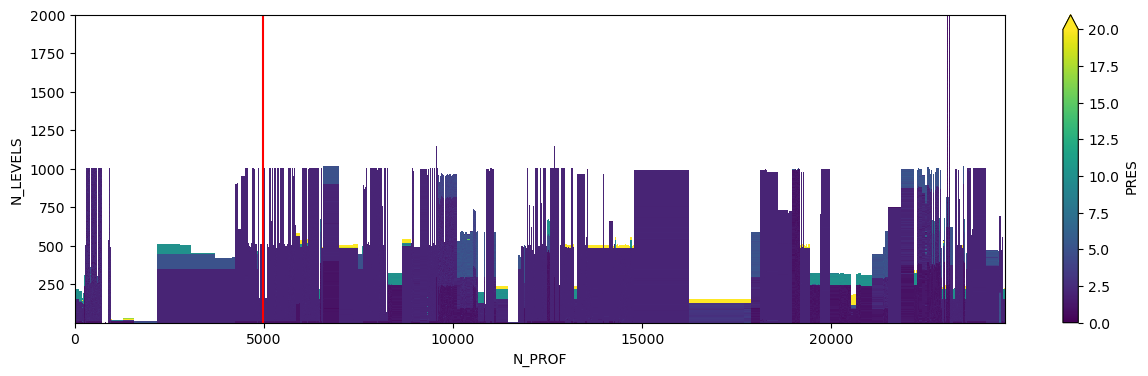

In [9]:
plt.figure(figsize=(15,4))
ds_rate.plot(x='N_PROF',y='N_LEVELS',vmin=0,vmax=20)
plt.axvline(4970,0,1000,color='r')#,linewidth=30)

In [12]:
ds_rate

<xarray.DataArray 'PRES' (N_PROF: 8667, N_LEVELS: 2001)> Size: 69MB
array([[0.9      , 1.       , 1.       , ...,       nan,       nan,
              nan],
       [0.9      , 1.1      , 0.9000001, ...,       nan,       nan,
              nan],
       [0.9      , 1.1      , 0.9000001, ...,       nan,       nan,
              nan],
       ...,
       [1.       , 1.       , 1.       , ...,       nan,       nan,
              nan],
       [1.       , 1.       , 1.       , ...,       nan,       nan,
              nan],
       [1.       , 1.       , 1.0999999, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * N_PROF     (N_PROF) int64 69kB 0 1 2 3 4 5 ... 24583 24584 24585 24586 24587
  * N_LEVELS   (N_LEVELS) int64 16kB 1 2 3 4 5 6 ... 1997 1998 1999 2000 2001
    TIME       (N_PROF) datetime64[ns] 69kB 2022-05-28T12:48:00 ... 2024-12-1...
    LATITUDE   (N_PROF) float64 69kB 17.19 17.33 17.31 ... 62.64 62.67 62.28
    LONGITUDE  (N_PROF) float64 69kB -23.2 -23.27 -23.38 ... -23.69 -24.0 -24.57

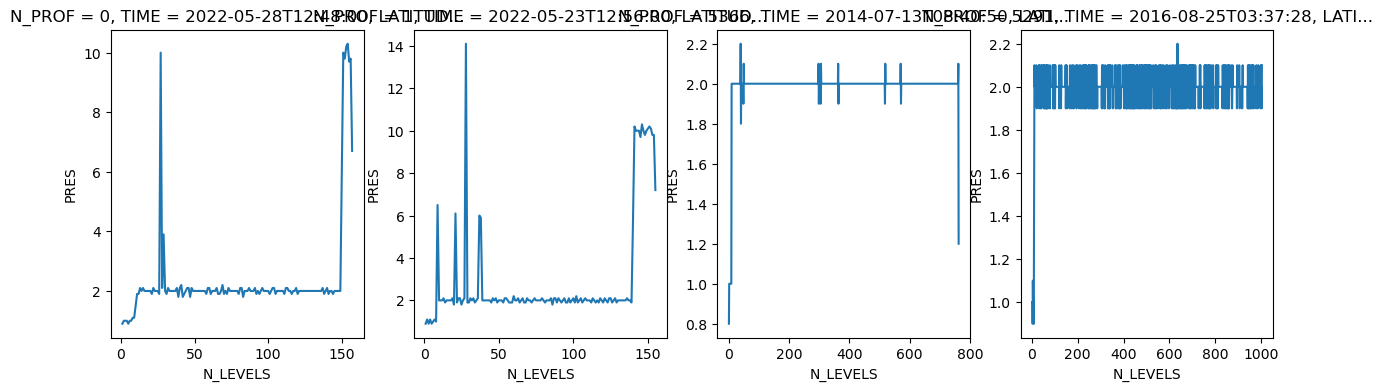

In [10]:
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
ds_rate.isel(N_PROF=0).plot()
plt.subplot(1,4,2)
ds_rate.isel(N_PROF=1).plot()
plt.subplot(1,4,3)
ds_rate.isel(N_PROF=1475).plot()
plt.subplot(1,4,4)
ds_rate.isel(N_PROF=1400).plot()

I can plot the sampling rate for each profile by `N_LEVEL` but I'm not entirely sure how to make this a variable based on the interpolated pressure grid. Because if I just feed it to the interp function, I'm pretty sure it will interpolate between the values which wouldn't make any sense. Somehow I need to make sure that every pressure level/depth range associated with one `N_LEVEL` reports the same sampling rate.

In [15]:
ds['sample_rate'] = ds_rate
ds_interp = prf.get_ds_interp(ds,0,2000,4)

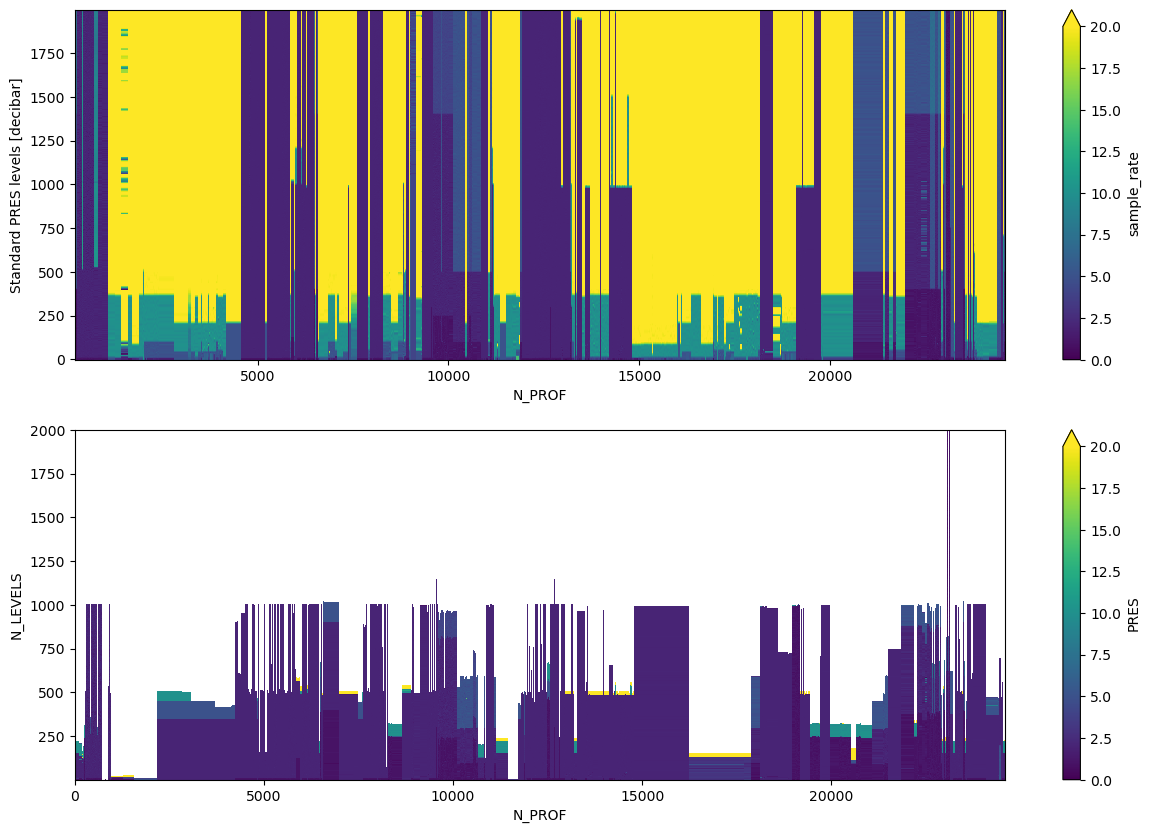

In [25]:
plt.figure(figsize=(15,10))

plt.subplot(211)
ds_interp.sample_rate.sortby('N_PROF').plot(x='N_PROF',y='PRES_INTERPOLATED',vmin=0,vmax=20)

plt.subplot(212)
ds_rate.plot(x='N_PROF',y='N_LEVELS',vmin=0,vmax=20)

In [21]:
ds_interp

<xarray.Dataset> Size: 40MB
Dimensions:            (N_PROF: 6652, PRES_INTERPOLATED: 500)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 53kB 2000-12-27T05:50:00 ... 2...
    LATITUDE           (N_PROF) float64 53kB -5.839 -6.022 ... -52.11 23.95
    LONGITUDE          (N_PROF) float64 53kB -23.33 -23.11 ... -23.33 -23.52
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 4kB 0 4 8 12 ... 1988 1992 1996
  * N_PROF             (N_PROF) int64 53kB 1266 1268 1261 ... 11001 6147 6223
    N_PROF_NEW         (N_PROF) int64 53kB 0 1 2 3 4 ... 6648 6649 6650 6651
Data variables:
    CYCLE_NUMBER       (N_PROF) int64 53kB 1 3 13 14 15 ... 216 177 196 69 251
    DATA_MODE          (N_PROF) <U1 27kB 'D' 'D' 'D' 'D' 'D' ... 'R' 'R' 'A' 'A'
    DIRECTION          (N_PROF) <U1 27kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) int64 53kB 39045 39045 39042 ... 1902088 1902208
    PRES               (N_PROF, PRES_INTERPOLATED) float32 13MB 3.2 ... 1.996...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 13MB 26.1 ... 3.967
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 13MB 3.8 3.8 ... 2.0
Attributes:
    raw_attrs:            {'raw_attrs': {'title': 'Argo float vertical profil...
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2024/12/12
    Fetched_constraints:  [x=-25.00/-23.00; y=-70.00/70.00; z=0.0/2001.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/6900719/6...
    Processing_history:   [PRES,TEMP] real-time and adjusted/delayed variable...

In [17]:
#try process with one profile, follow through all steps, check intuition

In [18]:
#for filtering: only take the part of the profile that has a sample rate >5m

In [20]:
plt.figure(figsize=(15,4))
ds_interp.SA.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

AttributeError: 'Dataset' object has no attribute 'SA'

<Figure size 1500x400 with 0 Axes>

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
ds_interp.sample_rate.isel(N_PROF=0).plot()
plt.subplot(1,3,2)
ds_interp.sample_rate.isel(N_PROF=260).plot()
plt.subplot(1,3,3)
ds_interp.sample_rate.isel(N_PROF=785).plot()

## Write new get_ds_interp function

In [34]:
## OLD get_ds_interp function

def old_ds_interp(ds,depth_min,depth_max,sample_rate):
    
    '''Takes an Argo xarray with sampled pressure and:
    1) only selects profiles that sample at a rate equal to or greater than sample_rate
    2) interpolates the pressure to a 2m grid.
    3) returns an xarray with all profiles that meet the sample rate interpolated at 2m, with a new dimension PRES_INTERPOLATED
    
    ds: xarray dataset with dimensions PRES, N_LEVELS, N_PROF; pressure PRES
    depth_min: shallowest depth selected[m]
    depth_max: deepest depth selected [m]
    sample_rate: minimum sample rate [m]'''
    
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_rate,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_sel

In [35]:
old_interp = old_ds_interp(ds,0,2001,4)
old_interp

<xarray.Dataset>
Dimensions:          (N_PROF: 1784, N_LEVELS: 1006)
Coordinates:
  * N_PROF           (N_PROF) int64 3805 3806 3807 3793 ... 3367 3467 4920 3635
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 ... 1001 1002 1003 1004 1005
    TIME             (N_PROF) datetime64[ns] 2011-11-15T15:38:35 ... 2023-08-...
    LATITUDE         (N_PROF) float64 -30.32 -30.98 -31.2 ... -34.39 -35.89
    LONGITUDE        (N_PROF) float64 -3.401 -3.714 -3.149 ... -5.363 -2.101
Data variables: (12/16)
    CYCLE_NUMBER     (N_PROF) int64 4 5 6 6 7 7 8 8 ... 36 209 246 246 109 52 37
    DATA_MODE        (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'R' 'R' 'R' 'A' 'R'
    DIRECTION        (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 3900833 3900833 3900833 ... 5906492 1902447
    POSITION_QC      (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 1.0 2.0 3.0 ... 1.998e+03 nan
    ...               ...
    PSAL_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TEMP             (N_PROF, N_LEVELS) float32 17.63 17.63 17.62 ... 2.737 nan
    TEMP_ERROR       (N_PROF) float32 0.002 0.002 0.002 0.002 ... nan nan nan
    TEMP_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 99999
    TIME_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    sample_rate      (N_PROF, N_LEVELS) float32 nan 1.0 1.0 1.0 ... 2.0 1.9 nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/08
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/aoml/1901544/190...
    history:              Variables filtered according to DATA_MODE; Variable...

In [36]:
def new_ds_interp(ds,depth_min=0,depth_max=2001,interp_step=2):
    '''
    '''
    dp = ds.PRES.diff('N_LEVELS').sortby('N_PROF')
    ds['sample_rate'] = dp
    ds_interp = ds.argo.interp_std_levels(np.arange(depth_min,depth_max,interp_step))
    
    return ds_interp

In [37]:
## NEW get_ds_interp function

def new_ds_interp(ds,depth_min=0,depth_max=2001,interp_step=2):
    '''
    '''
    dp = ds.PRES.diff('N_LEVELS').sortby('N_PROF')
    ds['sample_rate'] = dp
    ds_interp = ds.argo.interp_std_levels(np.arange(depth_min,depth_max,interp_step))
    
    return ds_interp

In [38]:
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 5776, N_LEVELS: 1006)
Coordinates:
  * N_PROF           (N_PROF) int64 4 5 6 7 8 9 ... 5592 2805 5637 3635 2927
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 ... 1001 1002 1003 1004 1005
    TIME             (N_PROF) datetime64[ns] 2002-12-11T14:47:32 ... 2023-08-...
    LATITUDE         (N_PROF) float64 -34.73 -34.61 -34.52 ... -35.89 -32.35
    LONGITUDE        (N_PROF) float64 -9.135 -9.183 -9.301 ... -2.101 -4.3
Data variables: (12/16)
    CYCLE_NUMBER     (N_PROF) int64 4 5 6 7 8 18 1 1 ... 109 52 50 140 49 37 106
    DATA_MODE        (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'R' 'R'
    DIRECTION        (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 1900058 1900058 1900058 ... 1902447 1901923
    POSITION_QC      (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 70.0 80.0 90.0 ... nan nan nan
    ...               ...
    PSAL_QC          (N_PROF) int64 1 1 1 1 1 1 2 2 2 1 ... 1 1 1 1 1 1 1 1 1 1
    TEMP             (N_PROF, N_LEVELS) float32 14.85 14.7 14.43 ... nan nan nan
    TEMP_ERROR       (N_PROF) float32 0.002 0.002 0.002 0.002 ... nan nan nan
    TEMP_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 ... 99999 99999 99999
    TIME_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    sample_rate      (N_PROF, N_LEVELS) float32 nan 10.0 10.0 ... nan nan nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/08
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/aoml/1901544/190...
    history:              Variables filtered according to DATA_MODE; Variable...

In [39]:
import processing_funcs as prf

In [40]:
%%time
box = prf.get_box([-10,0,-40,-30,0,2000], 0, 1800, 2)

loading points complete


/home/amf2288/mambaforge-pypy3/envs/argo_Aug_23/lib/python3.10/site-packages/argopy/data_fetchers/gdacftp_data.py:316: UserWarning: Found more than 50 files to load, this may take a while to process sequentially ! Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time.
  warnings.warn(
100%|██████████| 205/205 [05:49<00:00,  1.70s/it]


to xarray complete
point to profile complete
interpolation complete
adding spice complete
adding MLD complete
CPU times: user 8min 52s, sys: 14.7 s, total: 9min 7s
Wall time: 9min 2s


In [46]:
box

<xarray.Dataset>
Dimensions:            (N_PROF: 4910, PRES_INTERPOLATED: 900)
Coordinates:
  * N_PROF             (N_PROF) int64 54 81 121 55 82 ... 2805 5637 3635 2927
    TIME               (N_PROF) datetime64[ns] 2003-12-03T01:12:32 ... 2023-0...
    LATITUDE           (N_PROF) float64 -30.04 -30.01 -30.23 ... -35.89 -32.35
    LONGITUDE          (N_PROF) float64 -8.244 -4.695 -1.791 ... -2.101 -4.3
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1792 1794 1796 1798
    N_PROF_NEW         (N_PROF) int64 0 1 2 3 4 5 ... 4905 4906 4907 4908 4909
    MLD                (N_PROF) int64 10 20 6 12 12 18 ... 148 132 188 120 130
    month              (N_PROF) int64 12 12 12 12 12 12 12 1 ... 7 7 8 8 8 8 8 8
    month_frac         (N_PROF) float64 12.1 12.13 12.17 ... 8.083 8.087 8.142
    year               (N_PROF) int64 2003 2003 2003 2003 ... 2023 2023 2023
    year_frac          (N_PROF) float64 2.004e+03 2.004e+03 ... 2.024e+03
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20.63 20.63 ... 2.649
    CYCLE_NUMBER       (N_PROF) int64 1 1 1 2 2 3 3 ... 109 52 50 140 49 37 106
    DATA_MODE          (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'R' 'R'
    DIRECTION          (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) int64 1900285 1900286 ... 1902447 1901923
    PRES               (N_PROF, PRES_INTERPOLATED) float32 4.5 4.5 ... 1.798e+03
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 35.85 35.85 ... 34.74
    SA                 (N_PROF, PRES_INTERPOLATED) float64 36.02 36.02 ... 34.91
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 25.24 25.24 ... 27.72
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 20.66 20.66 ... 2.781
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 4.8 4.8 ... 50.21
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 4.322 ... 0.03573
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/08
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/aoml/1901544/190...
    history:              Variables filtered according to DATA_MODE; Variable...

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
sns.heatmap(box.sample_rate)

<Axes: title={'center': 'N_PROF = 4190, TIME = 2019-05-21T19:43:30, LATI...'}>